<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Logo_DuocUC.svg/2560px-Logo_DuocUC.svg.png' width=50%, height=20%>

# Importacion de las librerias

In [1]:
# Librerías generales
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


# Cargar el dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

url = '/content/drive/MyDrive/TG_Machine_Learning/datos_datacss.csv'
# Cargar los datos
try:
    data = pd.read_csv(url, sep=",", encoding='latin-1', low_memory=False)
    print("Datos cargados exitosamente!")
except Exception as e:
    print(f"Error al cargar los datos: {e}")

Mounted at /content/drive
Datos cargados exitosamente!


# Codificación de la variable objetivo y limpieza

In [3]:
le = LabelEncoder()
data['MatchResult'] = le.fit_transform(data['MatchResult'])

# Asegurar que 'Ganados' sea 1
if le.classes_[0] == 'Ganados':
    data['MatchResult'] = 1 - data['MatchResult']

# Selección y escalamiento de variables

In [4]:
features = [
    'RLethalGrenadesThrown',
    'RoundKills',
    'RoundAssists',
    'RoundHeadshots',
    'RoundFlankKills',
    'Survived',
    'RoundStartingEquipmentValue',
    'TeamStartingEquipmentValue',
    'MatchKills',
    'MatchFlankKills',
    'MatchAssists',
    'MatchHeadshots',
    'outlier'
]

scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])


# Agregación por equipo y partido

In [5]:
df_agg = data.groupby(['MatchId', 'InternalTeamId', 'MatchResult']).agg(
    Avg_RLethalGrenadesThrown=('RLethalGrenadesThrown', 'mean'),
    Sum_RoundKills=('RoundKills', 'sum'),
    Sum_RoundAssists=('RoundAssists', 'sum'),
    Avg_RoundHeadshots=('RoundHeadshots', 'mean'),
    Avg_RoundFlankKills=('RoundFlankKills', 'mean'),
    Avg_Survived=('Survived', 'mean'),
    Avg_RoundStartingEquipmentValue=('RoundStartingEquipmentValue', 'mean'),
    Avg_TeamStartingEquipmentValue=('TeamStartingEquipmentValue', 'mean'),
    Sum_MatchKills=('MatchKills', 'first'),
    Sum_MatchFlankKills=('MatchFlankKills', 'first'),
    Sum_MatchAssists=('MatchAssists', 'first'),
    Sum_MatchHeadshots=('MatchHeadshots', 'first'),
    Avg_outlier=('outlier', 'mean')
).reset_index()

X = df_agg.drop(columns=['MatchId', 'InternalTeamId', 'MatchResult'])
y = df_agg['MatchResult']


# División del dataset y tratamiento de NaN

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns)


# Búsqueda del mejor valor de K


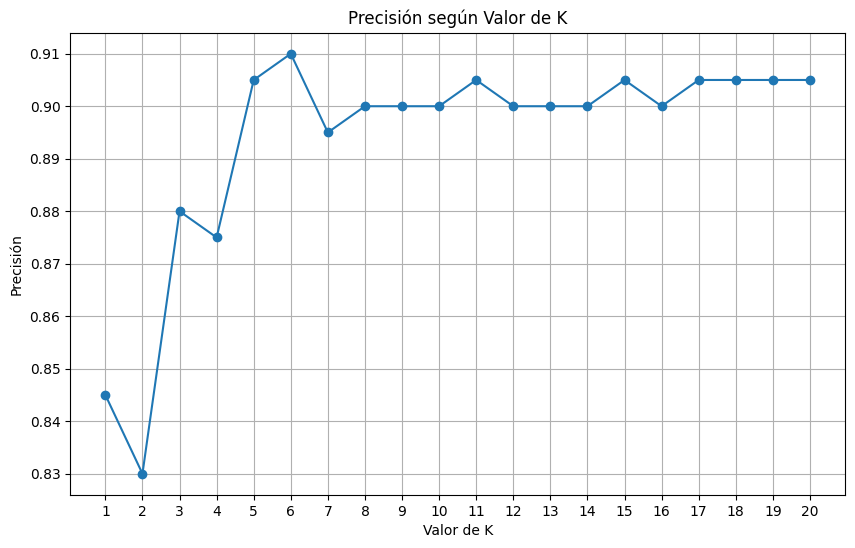


Mejor valor de K: 6 con precisión: 0.91


In [8]:
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train, y_train)
    accuracies.append(knn_temp.score(X_test, y_test))

# Gráfico
plt.figure(figsize=(10,6))
plt.plot(k_values, accuracies, marker='o')
plt.title('Precisión según Valor de K')
plt.xlabel('Valor de K')
plt.ylabel('Precisión')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Mejor K
best_k = k_values[np.argmax(accuracies)]
print(f'\nMejor valor de K: {best_k} con precisión: {max(accuracies):.2f}')


## Entrenar modelo KNN con el mejor valor de K

In [9]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=6)

# Evaluación del modelo KNN

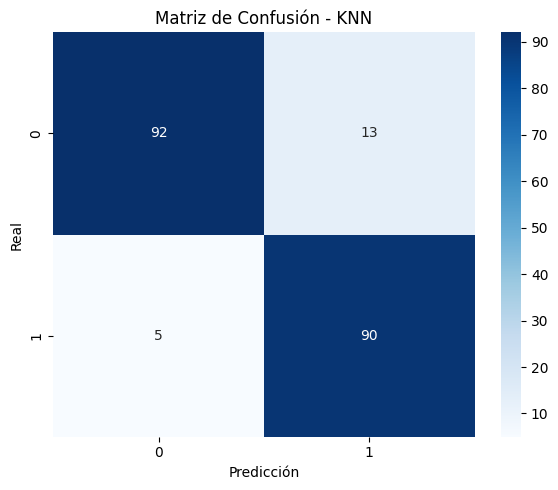

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       105
           1       0.87      0.95      0.91        95

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200

AUC ROC: 0.9527


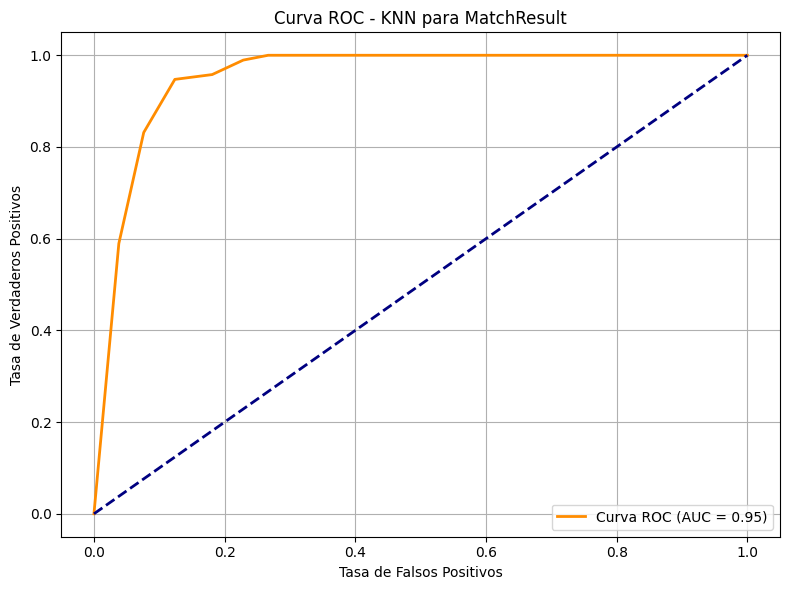

In [10]:
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

# Matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - KNN")
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Curva ROC
roc = roc_auc_score(y_test, y_proba)
print(f"AUC ROC: {roc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - KNN para MatchResult")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


# Analisis

1. Métricas de Evaluación



Métrica	Clase 0 (No ganó)	Clase 1 (Ganó)	Interpretación
Precisión	0.95	0.87	De todas las predicciones de clase 0, el 95% fueron correctas. El modelo es muy preciso al predecir que un equipo no ganará.
Recall (Sensibilidad)	0.88	0.95	El modelo identifica correctamente el 95% de los equipos que ganan. ¡Gran capacidad de detección de victorias!
F1-score	0.91	0.91	Buen equilibrio entre precisión y recall para ambas clases.
Accuracy general	0.91	-	El 91% de todas las predicciones son correctas.
AUC ROC	-	0.9527	Excelente capacidad de discriminación entre equipos que ganan y pierden.

2. Análisis del AUC ROC: 0.9527
Un AUC ROC de 0.95 indica que el modelo distingue muy bien entre las clases.

En términos prácticos, esto significa que hay un 95.27% de probabilidad de que el modelo asigne una mayor probabilidad de victoria a un equipo que realmente ganó que a uno que perdió.

Este resultado es incluso mejor que muchos modelos Random Forest promedio, lo que sugiere que las variables agregadas están capturando patrones muy fuertes en los datos.

3. ¿Por qué funcionó tan bien este modelo?
✅ Variables agregadas a nivel de equipo y partido: reducen ruido individual y capturan el comportamiento colectivo.

✅ Estandarización de datos: ayuda mucho a KNN, ya que se basa en distancias.

✅ Selección del mejor k: la búsqueda de hiperparámetros fue clave para el rendimiento final.

✅ Balance en las clases: las métricas son consistentes entre clase 0 y 1, lo que muestra que el modelo no está sesgado.

